In [1]:
import torch
from torchinfo import summary
from tqdm import tqdm
import TorchData
from sklearn.metrics import roc_auc_score,  f1_score
import matplotlib.pyplot as plt

In [2]:
import importlib
importlib.reload(TorchData)

<module 'TorchData' from '/home/lukelele/Documents/ResearchProject/TorchData/__init__.py'>

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [4]:
NUM_DATA = 1024
BATCH_SIZE = 256
EPOCH = 100

In [5]:
train_dataset = TorchData.TORCHDataset(num_data=NUM_DATA)
train_dataloader = train_dataset.dataloader(batch_size=BATCH_SIZE, shuffle=True)

In [6]:
test_dataset = TorchData.TORCHDataset(num_data=1)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

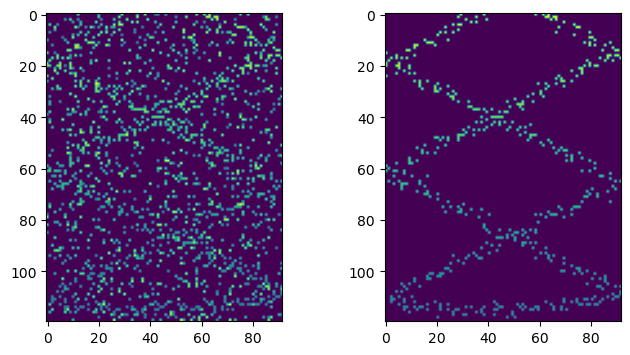

In [7]:
x, y = next(iter(train_dataloader))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(x[0, 0])
ax[1].imshow(y[0, 0])

In [58]:
class ConvolutionAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 3, stride=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [59]:
model = ConvolutionAutoencoder()
model = torch.nn.DataParallel(model)
model = model.to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [60]:
summary(model, input_size=(1, 1, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [1, 1, 120, 92]           --
├─ConvolutionAutoencoder: 1-1            [1, 1, 120, 92]           --
│    └─Sequential: 2-1                   [1, 8, 114, 86]           --
│    │    └─Conv2d: 3-1                  [1, 64, 118, 90]          640
│    │    └─BatchNorm2d: 3-2             [1, 64, 118, 90]          128
│    │    └─ReLU: 3-3                    [1, 64, 118, 90]          --
│    │    └─Conv2d: 3-4                  [1, 16, 116, 88]          9,232
│    │    └─BatchNorm2d: 3-5             [1, 16, 116, 88]          32
│    │    └─ReLU: 3-6                    [1, 16, 116, 88]          --
│    │    └─Conv2d: 3-7                  [1, 8, 114, 86]           1,160
│    │    └─BatchNorm2d: 3-8             [1, 8, 114, 86]           16
│    │    └─ReLU: 3-9                    [1, 8, 114, 86]           --
│    └─Sequential: 2-2                   [1, 1, 120, 92]           --
│    │ 

In [61]:
for epoch in tqdm(range(EPOCH)):
    for x, y in train_dataloader:
        optimiser.zero_grad()
        outputs = model(x.to(device))
        loss = loss_function(outputs, y.to(device))
        loss.backward()
        optimiser.step()

100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


In [62]:
# torch.save(model.state_dict(), f"Conv2Channel_{NUM_DATA}_{BATCH_SIZE}_{EPOCH}.pth")

In [63]:
### Using pretrained weights
# model.load_state_dict(torch.load(f"Conv2Channel_14f98cf2-5312-428f-b095-3447495b69ec.pth"))

In [64]:
model.eval()
all_pred = []
model = model.to("cuda")
with torch.inference_mode():
    for sn_time, signal_time in test_dataloader:
        sn_time = sn_time.to("cuda")
        pred = model(sn_time)
        all_pred.append(pred)
    all_pred = torch.cat(all_pred)

all_pred_time = all_pred.to("cpu") * test_dataset.sn_time.to("cpu")
all_pred_time[all_pred_time < 0.5] = 0

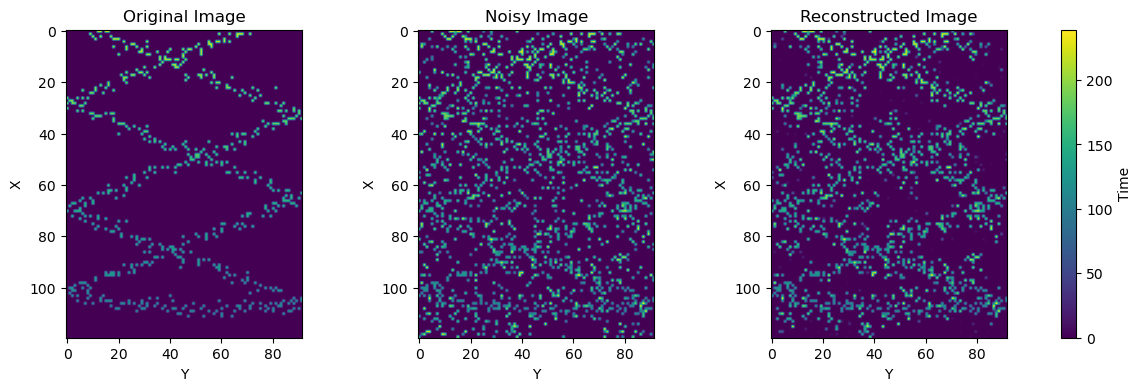

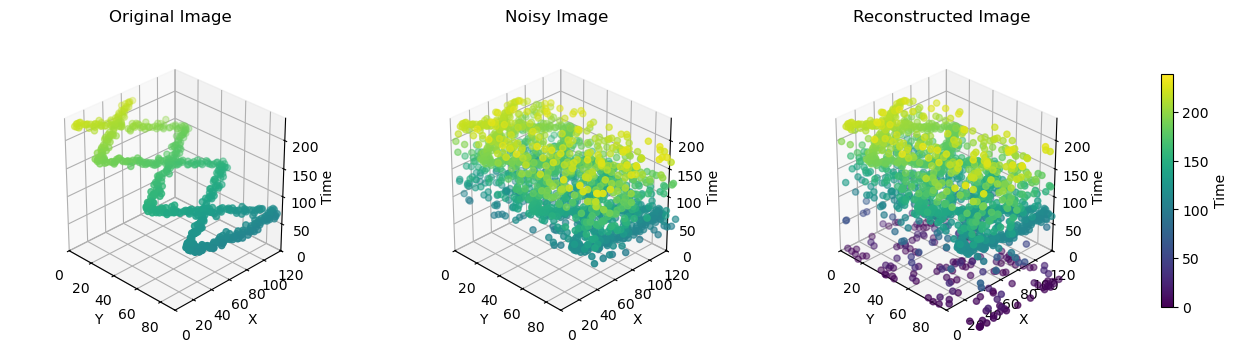

In [65]:
TorchData.visual.fast_compare_plot(test_dataset, all_pred_time.cpu(), 0)

In [75]:
pred_list = [
    {"name": "Time Value Image", "data": all_pred_time},
]
for i in pred_list:
    print(f"Metrics for {i['name']}:")
    mse = TorchData.metric.calculate_mse_torch(test_dataset.signal_time, i["data"])
    roc_auc = roc_auc_score(test_dataset.signal.flatten().numpy(), i["data"].flatten().numpy())
    print(f"MSE: {mse:.4f}, ROC AUC: {roc_auc:.4f}")

Metrics for Time Value Image:
MSE: 1995.3517, ROC AUC: 0.9608
